In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
from google.colab import drive
drive.mount('/content/drive')
# device='cuda' if torch.cuda.is_available() else 'cpu',print(torch.cuda.get_device_name(0))


filenames=['./drive/My Drive/gnn/ieee24_rts_6183exact_0810.txt', # exact nodal injection (generator included)
           './drive/My Drive/gnn/data/ieee118_dc_7859_price_lambda.txt', # load file (no gen)
           './drive/My Drive/gnn/data/ieee118_dc_8000_cost2price.txt',
           './drive/My Drive/gnn/data/ieee118_dc_8000_3input2price.txt',
           '/content/drive/MyDrive/gnn/data/ieee118_dc_8000_3input2price_new.txt'
           '/content/drive/MyDrive/gnn/data/ieee118_dc_10000_3input2price.txt',
           '/content/drive/MyDrive/gnn/data/ieee118_dc_10000_3input2price_p10.txt',
           '/content/drive/MyDrive/gnn/data/ieee118_ac_20000_3input2price_p10_1.txt',
           '/content/drive/MyDrive/gnn/data/data_2383_linkpred/ieee2383_dc_3input_p10_factive_1.txt']
filename=filenames[-1]

Mounted at /content/drive


In [ ]:
x1 = np.load('/content/drive/MyDrive/gnn/data/data_2383dc_quad_cost/2383dc_plimit_x.npy')
y1 = np.load('/content/drive/MyDrive/gnn/data/data_2383dc_quad_cost/2383dc_plimit_y.npy')

x1 = np.delete(x1,obj=3,axis=1)
print(x1.shape,y1.shape)

filepath = '/content/drive/My Drive/gnn/data/data_2383dc_topo_3inputs/' # DC-OPF

np.save(filepath + 'pickle/dc2383_x_set3.npy',arr=x1)
np.save(filepath + 'pickle/dc2383_y_set3.npy',arr=y1)

(2383, 3, 6316) (2383, 6316)


# Nominal system

In [ ]:
# filepath = '/content/drive/My Drive/gnn/data/data_118dc_3input/ieee118' # AC-OPF
filepath = '/content/drive/My Drive/gnn/data/data_2383dc_topo_3inputs/ieee2383dc' # DC-OPF

data=pd.read_table(filename,sep=',',header=None).to_numpy()
## load injection
# system size
n_bus=int(data[0,0].copy())
# n_bus = 2383
n_line=int(data[1,0].copy()) # not concatenated
# n_line=179
n_double_line = 9
n_line = n_line - n_double_line
n_gen = int(data[4,0].copy())
n_load=int(data[2,0].copy())
n_sample=int(data[3,0].copy())
# line
line_bus=data[:,1:3].copy()


# load data
filename = filepath + '_topo_topo_load.txt' # load file (no gen)
load_data0 = pd.read_table(filename,sep=',',header=None).to_numpy()

n_sample0 = np.size(load_data0,1)
# generator cost data
filename = filepath + '_topo_topo_cost.txt' 
gen_cost0 = pd.read_table(filename,sep=',',header=None).to_numpy()
# generator limit data
filename = filepath + '_topo_topo_pgmax.txt' 
gen_limit0 = pd.read_table(filename,sep=',',header=None).to_numpy()
# LMP data
filename = filepath + '_topo_lmp_nominal.txt' 
lmp_data = pd.read_table(filename,sep=',',header=None).to_numpy()
# generation data
filename = filepath + '_topo_gen_nominal.txt' 
gen_data = pd.read_table(filename,sep=',',header=None).to_numpy()

y0=lmp_data.copy()
print(n_bus,n_sample)
print(np.max(gen_cost0),np.min(gen_cost0))
print(load_data0.shape,gen_cost0.shape,gen_limit0.shape,lmp_data.shape,gen_data.shape)
# Use partial data for faster test
n_sample=n_sample0
load_data=np.zeros((n_bus,3,n_sample))

# efficient index
filename = filepath + '_topo_topo_effective_index.txt' 
eff_idx0 = pd.read_table(filename,sep=',',header=None).to_numpy()
eff_idx_node = eff_idx0[:,0]
n_sample_nominal = sum(eff_idx_node)
eff_idx_node1 = np.where(eff_idx_node >0)
eff_idx_node1 = eff_idx_node1[0]

load_data[:,0,:]=load_data0[:,:n_sample].copy()
# load_data[:,1,:]=gen_cost0[:,:n_sample].copy()
# load_data[:,2,:]=gen_limit0[:,:n_sample].copy()
for i in range(n_sample_nominal):
  load_data[:,1,eff_idx_node1[i]-1]=gen_cost0[:,i].copy()
  load_data[:,2,eff_idx_node1[i]-1]=gen_limit0[:,i].copy()
y0=y0[:,:n_sample].copy()*1

# print system info
print('Nominal system (w/out outage):')
print('Test case: ',filename)
print('Number of buses: ',n_bus)
print('Number of lines: ',n_line)
print('Number of loads: ',n_load)
print('Number of samples: ',n_sample,'Efficient:',n_sample_nominal)

2383 3952
170.76 0.0
(2383, 4000) (2383, 2943) (2383, 2943) (2383, 2943) (2383, 2943)
Nominal system (w/out outage):
Test case:  /content/drive/My Drive/gnn/data/data_2383dc_topo_3inputs/ieee2383dc_topo_topo_effective_index.txt
Number of buses:  2383
Number of lines:  2887
Number of loads:  1822
Number of samples:  4000 Efficient: 2943


In [ ]:
# load_data.shape
# n_sample
# test1 = np.where(eff_idx_node >0)
# np.size(test1)
print(np.where(load_data[:,1,:]>0))
np.where(gen_cost0>0)

(array([   9,    9,    9, ..., 1882, 1882, 1882]), array([   0,    1,    2, ..., 3996, 3997, 3998]))


(array([   9,    9,    9, ..., 1882, 1882, 1882]),
 array([   0,    1,    2, ..., 2940, 2941, 2942]))

In [ ]:
# # filename = './drive/My Drive/gnn/data/ieee118_nominal_price.txt' # load file (no gen)
# filename='./drive/My Drive/gnn/data/ieee118_nominal_cost2price.txt'
# nominal_data=pd.read_table(filename,sep=',',header=None).to_numpy() # range [-0.4,0.5]
# load_nominal=nominal_data[:,0].copy()
# lmp_nominal=nominal_data[:,1].copy()
# for i in range(n_sample):
#   # load_data[:,i] = load_data[:,i] - load_nominal
#   y0[:,i] = y0[:,i] #- lmp_nominal
#   load_data[:,:,i] = load_data[:,:,i] #- load_nominal  #/ 400
# # y0 = y0 / 1500
# # load_data = np.log(load_data+1) # +1 to avoid -inf in load, scaling / 300
# # y0 = np.log(y0) 

print(load_data.shape,y0.shape)
# print(load_data[:,1:5],y0[:,1:5])
# print(np.max(load_data),np.min(load_data),np.max(y0),np.min(y0),max(lmp_nominal),min(lmp_nominal))

(2383, 3, 4000) (2383, 2943)


In [ ]:
# filename='./drive/My Drive/gnn/data/ieee118_Bbus.txt' # load file (no gen)
# B=pd.read_table(filename,sep=',',header=None).to_numpy() # range [-0.4,0.5]
# print(B.shape,type(B))

line_src=line_bus[:,0].copy().astype(int)
line_dst=line_bus[:,1].copy().astype(int)
print('Original graph:')
print('There are %d nodes.' % n_bus)
print('There are %d edges.' % n_line)

# adjacency
def graph_v2v_mat(line,n_line,n_bus):
	w = np.zeros((n_bus,n_bus))
	for i in range(n_line):
		# print(int(line[i,0]),int(line[i,1]))
		w[int(line[i,0])-1,int(line[i,1])-1] = 1
		w[int(line[i,1])-1,int(line[i,0])-1] = 1
	return w

def graph_laplacian(line,n_line,n_bus):
	incidence = np.zeros((n_line,n_bus))
	for i in range(n_line):
		# print(int(line[i,0]),int(line[i,1]))
		incidence[i,int(line[i,0])-1] = incidence[i,int(line[i,0])-1] + 1 # source
		incidence[i,int(line[i,1])-1] = incidence[i,int(line[i,1])-1] - 1 # destination
	w = np.matmul(incidence.transpose(),incidence)
	return w
W = graph_laplacian(line_bus,n_line,n_bus) # v2v
A = graph_v2v_mat(line_bus,n_line,n_bus)
# W=np.abs(W)

Original graph:
There are 2383 nodes.
There are 2887 edges.


In [ ]:
print(line_bus.shape,n_line,n_bus)

(2887, 2) 2887 2383


In [ ]:
# print(W)
# w1 = np.matmul(W,W)
# a1 = np.matmul(A,A)
# print(W[1,:])
# print(np.sum(w1[1,:]),w1[1,:])
# print(A[1,:])
# print(a1[1,:])
load_data.shape

(2383, 3, 4000)

In [ ]:
# # Set the ratio of training/test set
# train_ratio = 0.8
# n_train = int(np.floor(train_ratio * n_sample))
# n_test = n_sample - n_train
# print('Data set size: ',n_sample,', training set size: ',n_train,', test set size: ',n_test)

# # Generate training set and test set
# from sklearn.model_selection import train_test_split
# x_train2, x_test2, y_train2, y_test2 = train_test_split(load_data[0:n_bus,:].transpose(), y0[:,0:n_sample].transpose(), test_size=0.2, random_state=23)

# print(x_train2.shape, y_train2.shape)
# x_train=x_train2.transpose()
# print(x_train.shape)
# x_test=x_test2.transpose()
# y_train=y_train2.transpose()
# y_test=y_test2.transpose()
x_all=load_data[0:n_bus,:]
y_all=y0[:,0:n_sample]

# print('Training data size:',x_train.shape)
# print('Training label size:',y_train.shape)

# def get_xy(index):
#     tempx=np.array([np.transpose(x_train)[index]])
#     x_train_one=torch.from_numpy(tempx).float()
#     x_train_one=x_train_one.transpose(0,1)

#     tempy=np.array([np.transpose(y_train)[index]])
#     y_train_one=torch.from_numpy(tempy).float()
#     y_train_one=y_train_one.transpose(0,1)

#     return x_train_one,y_train_one

# # generate torch y_train for concatenated obj
# y_train1 = torch.from_numpy(y_train)#.float()
# # expand into 3d tensor 
# y_train1.unsqueeze_(-1)
# y_train1 = y_train1.expand(n_bus,n_train,1)
# y_train1 = y_train1.transpose(2,1)
# print(y_train1.shape)

In [ ]:
# system parameters
sys_params = data[:,0:3].copy()
sys_params[3,0] = n_sample0
print(sys_params[3,0])

4000.0


In [ ]:
# filepath1 = '/content/drive/My Drive/gnn/data/data_118ac_topo_3inputs_new1' # AC-OPF
filepath1 = '/content/drive/My Drive/gnn/data/data_2383dc_topo_3inputs' # DC-OPF
np.save(filepath1+'/pickle/dc2383_p10_x_nominal.npy',arr=x_all)
np.save(filepath1+'/pickle/dc2383_p10_y_nominal.npy',arr=y_all)
np.save(filepath1+'/pickle/dc2383_p10_w_nominal.npy',arr=W)
np.save(filepath1+'/pickle/dc2383_p10_sys_nominal.npy',arr=sys_params)

# Perturbed system

In [ ]:
# filepath = '/content/drive/My Drive/gnn/data/data_118dc_3input/'
filename = filepath + '_topo_topo_effective_index.txt'
effective_index = pd.read_table(filename,sep=',',header=None).to_numpy()
print(effective_index.shape)

n_group = 2
for i in range(n_group):
  filename = filepath + '_topo_topo_effective_index' + str(i+1) + '.txt'
  effective_index1 = pd.read_table(filename,sep=',',header=None).to_numpy()
  effective_index = np.append(effective_index,effective_index1,axis=1)

print(effective_index.shape)

topo_pert_num = np.size(effective_index,1) - 1
print('Systems w/ topo. perturb:',topo_pert_num)

effective_samples0 = np.sum(effective_index[:,0],0)
effective_index0 = effective_index[:,0].copy()

effective_samples = np.sum(effective_index[:,1:],0)
print('Nominal effective samples:',effective_samples0)
print('Effective samples for topo. changes:',effective_samples)

(4000, 3)
(4000, 7)
Systems w/ topo. perturb: 6
Nominal effective samples: 2943
Effective samples for topo. changes: [2943 2943 2943 2943 2943 2943]


In [ ]:
filename = filepath1 + '/2383dc_recorded_deletion_idx.txt' # load file (no gen)
del_idx = pd.read_table(filename,sep=',',header=None).to_numpy()

for i in range(n_group):
  filename = filepath1 + '/2383dc_recorded_deletion_idx' + str(i+1) + '.txt'
  del_idx1 = pd.read_table(filename,sep=',',header=None).to_numpy()
  del_idx = np.append(del_idx,del_idx1,axis=1)

print(del_idx.shape)

np.save(filepath1 + '/pickle/dc2383_p10_deletion_idx.npy',arr=del_idx)

(2896, 6)


In [ ]:
flow_pert = [] # list of np arries with length 5
gen_pert = []
lmp_pert = []
for i in range(topo_pert_num):
  # flow
  filename = filepath + '_topo_topo_flow_perturb'+ str(i+1) + '.txt'
  flow_pert.append(pd.read_table(filename,sep=',',header=None).to_numpy())
  # generation
  filename = filepath + '_topo_topo_gen_perturb'+ str(i+1) + '.txt'
  gen_pert.append(pd.read_table(filename,sep=',',header=None).to_numpy())
  # price
  filename = filepath + '_topo_topo_lmp_perturb'+ str(i+1) + '.txt'
  print(filename)
  lmp_pert.append(pd.read_table(filename,sep=',',header=None).to_numpy())



In [ ]:
# print(lmp_pert.shape,gen_pert.shape)
print(np.size(lmp_pert))
lmp_pert[0].shape

42079014


(2383, 2943)

In [ ]:
np.save(filepath1 + '/pickle/dc2383_p10_effective_idx.npy',arr=effective_index)

In [ ]:
np.save(filepath1 + '/pickle/dc2383_p10_gen_pert.npy',arr=gen_pert)
np.save(filepath1 + '/pickle/dc2383_p10_y_pert.npy',arr=lmp_pert)
# np.save('/content/drive/MyDrive/gnn/data/data_dc118_3input/pickle/dc118_p10_w_nominal.npy',arr=W)

In [ ]:
print(np.size(gen_pert),np.size(lmp_pert))

42079014 42079014


In [ ]:
# lmp_pert[0].shape
pert_size = np.size(lmp_pert[0],1)
for i in range(topo_pert_num):
  # print(lmp_pert[i].shape)
  print(np.max(np.abs(y_all[:,:pert_size] - lmp_pert[i])))

5840.09
481.32
462.69
466.76
473.4
863.66


# Data Analysis

In [ ]:
y_all.shape

(118, 7000)

In [ ]:
filepath = '/content/drive/My Drive/gnn/data/data_118ac_topo_3inputs_new/'
filename = filepath + '118ac_recorded_deletion_idx.txt' # load file (no gen)
del_idx = pd.read_table(filename,sep=',',header=None).to_numpy()
print(del_idx.shape)
del_num = np.sum(del_idx,0)

(186, 9)


In [ ]:
for i in range(topo_pert_num):
  print(np.where(del_idx[:,i]>0))

(array([162]),)
(array([94]),)
(array([173]),)
(array([ 93, 140]),)
(array([162]),)
(array([105, 162]),)
(array([154]),)
(array([30]),)
(array([56]),)


In [ ]:
print(y_all[:,0])
print(lmp_pert[0][:,0])
for i in range(topo_pert_num):
  # print(y_all[:,0] - lmp_pert[i][:,0])
  print('------------------')
  # print(np.mean(y_all[:,0] - lmp_pert[i][:,0]),np.max(y_all[:,0] - lmp_pert[i][:,0]))
  # print(lmp_pert[0][:,0] - lmp_pert[i][:,0])
  print(np.mean(lmp_pert[0][:,0]  - lmp_pert[i][:,0]),np.max(lmp_pert[0][:,0]  - lmp_pert[i][:,0]))
  # print(gen_pert[0][:,0] - gen_pert[i][:,0])

[32.165 32.039 31.764 30.689 30.594 31.366 31.528 30.613 29.924 29.225
 31.514 31.722 31.982 31.914 31.816 31.766 31.066 31.566 31.809 31.891
 31.769 31.413 30.633 30.622 29.717 29.79  31.771 31.984 31.95  30.914
 31.834 31.713 31.836 31.41  31.526 31.53  31.28  31.04  32.495 32.936
 33.013 32.561 31.831 31.607 31.346 30.718 30.347 30.474 30.273 30.864
 31.472 31.686 31.688 31.434 31.483 31.466 31.399 31.563 29.547 29.555
 29.407 29.668 29.496 29.438 29.367 29.584 29.789 28.87  28.671 30.77
 30.804 30.878 30.822 30.977 30.59  30.839 28.869 28.92  28.792 28.081
 28.406 27.718 27.157 25.926 25.221 25.581 25.581 24.538 23.862 25.396
 25.2   24.713 25.498 26.076 26.864 27.421 27.845 27.164 26.11  25.043
 25.114 24.862 25.895 26.588 26.936 27.058 27.797 27.321 27.464 27.759
 27.759 28.48  31.172 31.829 31.841 28.903 32.044 30.796]
[29.1   28.983 28.739 27.772 27.686 28.379 28.523 27.697 27.099 26.492
 28.509 28.693 28.921 28.856 28.737 28.717 28.048 28.502 28.723 28.769
 28.638 28.291 27.54

In [ ]:
# n_sample
lmp_dev = np.zeros((n_sample,topo_pert_num))
for i in range(topo_pert_num):
  for j in range(pert_size):
    lmp_dev[j,i] = np.linalg.norm(lmp_pert[i][:,j] - y_all[:,j]) / np.linalg.norm(y_all[:,j])



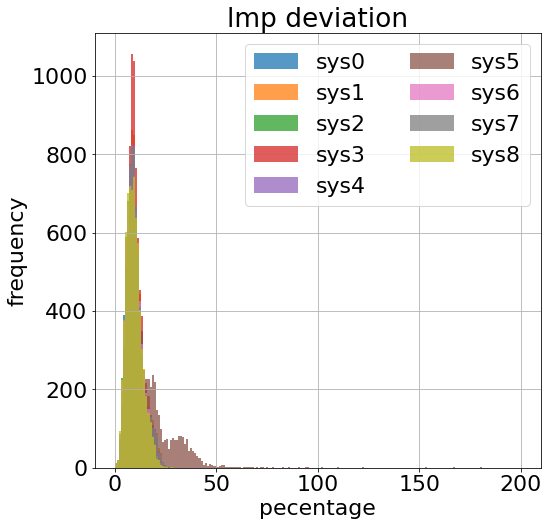

In [ ]:
plt.rcParams.update({'font.size': 22})
fig2 = plt.figure(figsize=(8, 8))
bins = np.linspace(0.0, .1, 50)
bins = np.linspace(0, 200, 200)
for i in range(topo_pert_num):
# for i in range(1):  
  name = 'sys' + str(i) #+ '('+ str(del_num[i]) + ')'
  plt.hist(lmp_dev[:,i]*100,bins, alpha = 0.75, label = name)
# name = 'nominal'
# plt.hist(err_expand1, bins, alpha = 0.75, label = name, color='darkorchid')
plt.legend(loc='upper right',ncol=2)
plt.xlabel('pecentage')
plt.ylabel('frequency')
plt.title('lmp deviation')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()